<a href="https://colab.research.google.com/github/Sjoneon/Bigdata2/blob/main/LastRealBigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#
# 셀 1: 환경 설정 및 라이브러리 설치
#
!pip install geopandas lightgbm

from google.colab import drive
drive.mount('/content/drive')

# 한글 시각화를 위한 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("="*50)
print("✅ 라이브러리 설치 및 폰트 설정이 완료되었습니다.")
print("‼️ 중요: Colab 메뉴에서 [런타임] > [세션 다시 시작]을 눌러주세요.")
print("="*50)

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,552 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database

In [15]:
#
# 셀 2 (수정): 누락된 라이브러리 임포트 추가
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import lightgbm as lgb      # [수정] lightgbm 임포트 추가
import geopandas as gpd     # [수정] geopandas 임포트 추가
from sklearn.metrics import r2_score
import warnings

# 기본 설정
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
pd.set_option('display.max_columns', None)

# 구글 드라이브 마운트
# 이전 셀에서 이미 세션이 다시 시작되었으므로, 여기서 다시 실행해줍니다.
drive.mount('/content/drive', force_remount=True)

print("✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.")

Mounted at /content/drive
✅ 라이브러리 임포트 및 기본 설정이 완료되었습니다.


In [2]:
#
# 셀 3: 데이터 로드
#
base_path = '/content/drive/My Drive/colab_data/'
def load_csv_robust(file_path):
    try: return pd.read_csv(file_path, encoding='cp949')
    except: return pd.read_csv(file_path, encoding='utf-8')

print("--- 데이터 로드 시작 ---")
df_store = load_csv_robust(base_path + '소상공인시장진흥공단_상가(상권)정보_서울_202503.csv')
df_realty = load_csv_robust(base_path + '서울시 부동산 실거래가 정보.csv')
df_sanggwon_pop = load_csv_robust(base_path + '서울시 상권분석서비스(길단위인구-상권).csv')
df_sanggwon_resident = load_csv_robust(base_path + '서울시 상권분석서비스(상주인구-상권).csv')
df_sanggwon_worker = load_csv_robust(base_path + '서울시 상권분석서비스(직장인구-상권).csv')
df_bus = load_csv_robust(base_path + 'BUS_STATION_BOARDING_MONTH_202505.csv')
df_subway = load_csv_robust(base_path + 'CARD_SUBWAY_MONTH_202505.csv')
print("--- 모든 데이터 로드 완료 ---")

--- 데이터 로드 시작 ---
--- 모든 데이터 로드 완료 ---


--- ✅ '서울시 상권분석서비스(직장인구-상권).csv' 파일 로드 성공! ---

[컬럼 목록]
Index(['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '총_직장_인구_수',
       '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수', '연령대_20_직장_인구_수',
       '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수',
       '연령대_60_이상_직장_인구_수', '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수',
       '남성연령대_30_직장_인구_수', '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수',
       '남성연령대_60_이상_직장_인구_수', '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수',
       '여성연령대_30_직장_인구_수', '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수',
       '여성연령대_60_이상_직장_인구_수'],
      dtype='object')

[데이터 미리보기]


,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,연령대_30_직장_인구_수,연령대_40_직장_인구_수,연령대_50_직장_인구_수,연령대_60_이상_직장_인구_수,남성연령대_10_직장_인구_수,남성연령대_20_직장_인구_수,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20251,A,골목상권,3110005,세검정,544,306,238,0,91,161,149,104,39,0,37,90,85,64,30,0,54,71,64,40,9
1,20251,A,골목상권,3110023,서울대병원,87,48,39,0,12,22,23,19,11,0,3,11,14,12,8,0,9,11,9,7,3
2,20251,D,발달상권,3120004,종로구청,5275,2909,2366,72,1068,1610,1447,826,252,31,466,808,849,583,172,41,602,802,598,243,80
3,20251,R,전통시장,3130019,동대문상가D동,7,3,4,0,0,1,3,2,1,0,0,0,1,1,1,0,0,1,2,1,0
4,20251,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),318,142,176,0,0,54,112,94,58,0,0,10,40,44,48,0,0,44,72,50,10


In [18]:
#
# 셀 4: 최종 데이터셋 구축
#
print("--- '시군구' 단위 최종 분석 데이터셋 구축 시작 ---")
seoul_gu_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']
df_final = pd.DataFrame({'시군구명': seoul_gu_list})
target_categories = ['소매', '음식', '생활서비스', '관광/여가/오락', '숙박', '스포츠']
df_store_filtered = df_store[df_store['상권업종대분류명'].isin(target_categories)]
store_count = df_store_filtered.groupby('시군구명').size().reset_index(name='고객대면_점포수')
df_final = pd.merge(df_final, store_count, on='시군구명', how='left')
realty_price = df_realty.groupby('자치구명')['물건금액(만원)'].mean().reset_index(name='평균부동산가(만원)')
realty_price.rename(columns={'자치구명': '시군구명'}, inplace=True)
df_final = pd.merge(df_final, realty_price, on='시군구명', how='left')
def get_gu_from_sanggwon(name, gu_list):
    for gu in gu_list:
        if gu in name: return gu
    return None
df_sanggwon_pop['시군구명'] = df_sanggwon_pop['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, seoul_gu_list) if isinstance(x, str) else None)
sanggwon_pop_agg = df_sanggwon_pop.groupby('시군구명')['총_유동인구_수'].sum().reset_index()
df_final = pd.merge(df_final, sanggwon_pop_agg, on='시군구명', how='left')
df_sanggwon_resident['시군구명'] = df_sanggwon_resident['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, seoul_gu_list) if isinstance(x, str) else None)
sanggwon_resident_agg = df_sanggwon_resident.groupby('시군구명')['총_상주인구_수'].sum().reset_index()
df_final = pd.merge(df_final, sanggwon_resident_agg, on='시군구명', how='left')
df_sanggwon_worker['시군구명'] = df_sanggwon_worker['상권_코드_명'].apply(lambda x: get_gu_from_sanggwon(x, seoul_gu_list) if isinstance(x, str) else None)
worker_agg = df_sanggwon_worker.groupby('시군구명')['총_직장_인구_수'].sum().reset_index(name='총_직장인구_수')
df_final = pd.merge(df_final, worker_agg, on='시군구명', how='left')
def get_gu_from_station_name(name, gu_list):
    for gu in gu_list:
        if gu in name or gu.replace('구', '') in name: return gu
    return None
df_bus['시군구명'] = df_bus['역명'].apply(lambda x: get_gu_from_station_name(str(x), seoul_gu_list))
bus_agg = df_bus.groupby('시군구명')[['승차총승객수', '하차총승객수']].sum().sum(axis=1).reset_index(name='버스_이용객수')
df_final = pd.merge(df_final, bus_agg, on='시군구명', how='left')
df_subway['시군구명'] = df_subway['역명'].apply(lambda x: get_gu_from_station_name(str(x), seoul_gu_list))
subway_agg = df_subway.groupby('시군구명')[['승차총승객수', '하차총승객수']].sum().sum(axis=1).reset_index(name='지하철_이용객수')
df_final = pd.merge(df_final, subway_agg, on='시군구명', how='left')
df_final.fillna({'버스_이용객수': 0, '지하철_이용객수': 0}, inplace=True)
df_final['대중교통_이용객수'] = df_final['버스_이용객수'] + df_final['지하철_이용객수']
leisure_categories = ['관광/여가/오락', '스포츠']
df_leisure_filtered = df_store[df_store['상권업종대분류명'].isin(leisure_categories)]
leisure_count = df_leisure_filtered.groupby('시군구명').size().reset_index(name='여가문화시설_수')
df_final = pd.merge(df_final, leisure_count, on='시군구명', how='left')
df_final = df_final.set_index('시군구명')
df_final.drop(columns=['버스_이용객수', '지하철_이용객수'], inplace=True, errors='ignore')
df_final.fillna(0, inplace=True)
print("\n--- ✅ 최종 분석용 데이터셋 (모든 변수 추가 완료) ---")
display(df_final.head())

--- '시군구' 단위 최종 분석 데이터셋 구축 시작 ---

--- ✅ 최종 분석용 데이터셋 (모든 변수 추가 완료) ---


,고객대면_점포수,평균부동산가(만원),총_유동인구_수,총_상주인구_수,총_직장인구_수,대중교통_이용객수,여가문화시설_수
시군구명,,,,,,,
종로구,12791,76270.842105,11145835.0,9162.0,269654.0,3679075.0,0.0
중구,15003,90634.627451,23757215.0,50208.0,159662.0,21920050.0,0.0
용산구,9549,186239.865995,9098509.0,21244.0,115734.0,2024441.0,0.0
성동구,8005,129574.962441,17217495.0,34660.0,12887.0,1175589.0,0.0
광진구,9388,93199.205545,24041356.0,89730.0,45020.0,605326.0,0.0


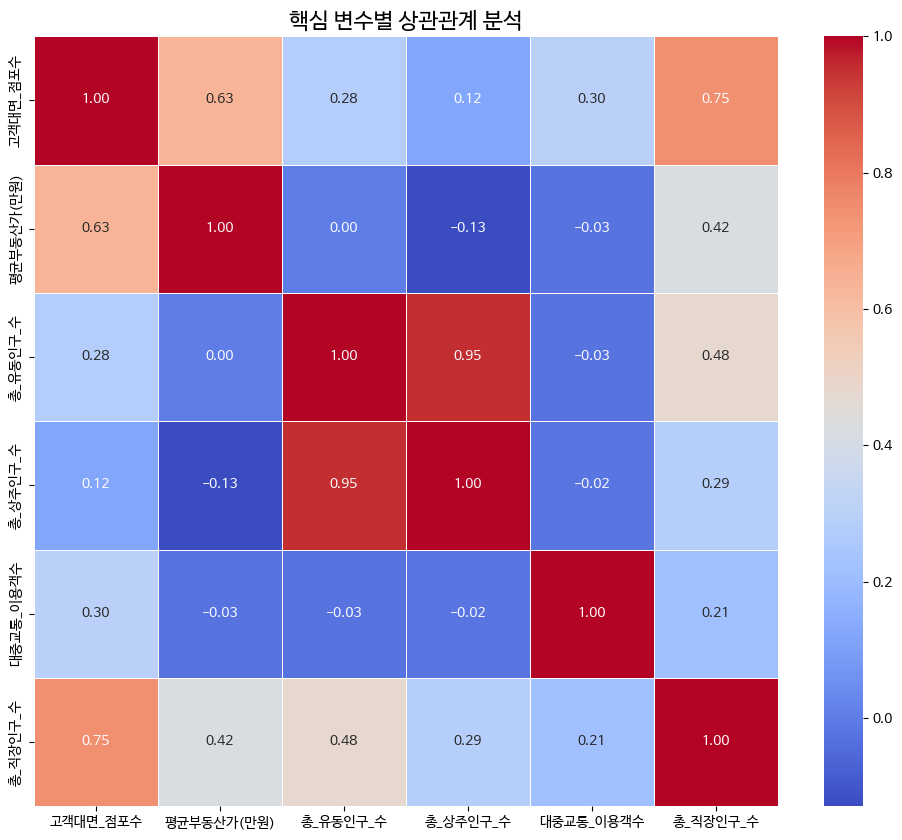

In [19]:
#
# 셀 5: 피처 상관관계 분석
#

# [수정] 히트맵에 포함할 변수 리스트에서 '여가문화시설_수'를 제외합니다.
heatmap_cols = ['고객대면_점포수', '평균부동산가(만원)', '총_유동인구_수', '총_상주인구_수', '대중교통_이용객수', '총_직장인구_수']
# df_final에 없는 컬럼은 오류 방지를 위해 자동으로 제외됩니다.
heatmap_cols = [col for col in heatmap_cols if col in df_final.columns]
df_corr = df_final[heatmap_cols]

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('핵심 변수별 상관관계 분석', fontsize=16)
plt.show()

In [22]:
#
# 셀 5: 모델링 및 결과 분석 (선형 회귀)
#
# 1. 데이터 준비
features = ['평균부동산가(만원)', '총_유동인구_수', '총_상주인구_수', '대중교통_이용객수', '총_직장인구_수']
X = df_final[features]
y_actual = df_final['고객대면_점포수']

# 데이터 스케일링 및 로그 변환
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_log = np.log1p(y_actual)

# 2. 선형 회귀 모델 학습 및 평가
linear_model = LinearRegression()
linear_model.fit(X_scaled, y_log)
log_predictions = linear_model.predict(X_scaled)
predictions = np.expm1(log_predictions).astype(int)
r2 = r2_score(y_actual, predictions)

print(f"--- 최종 모델 성능 (선형 회귀 + 모든 변수) ---")
print(f"✅ 모델 설명력(R²): {r2:.2%}")
print("="*40)

# 3. 변수 영향력(계수) 확인
coefficients = pd.DataFrame({'feature': features, 'coefficient': linear_model.coef_})
print("--- 각 변수가 점포 수에 미치는 영향력 ---")
display(coefficients.sort_values(by='coefficient', ascending=False))

# 4. '적정 점포수' 계산 및 결과 저장
df_final['적정_점포수'] = predictions
df_final['포화도_지수'] = df_final['고객대면_점포수'] - df_final['적정_점포수']

--- 최종 모델 성능 (선형 회귀 + 모든 변수) ---
✅ 모델 설명력(R²): 69.10%
--- 각 변수가 점포 수에 미치는 영향력 ---


,feature,coefficient
0,평균부동산가(만원),0.147586
4,총_직장인구_수,0.119813
3,대중교통_이용객수,0.084716
1,총_유동인구_수,0.051038
2,총_상주인구_수,-0.017326


--- 서울시 시군구별 실제 vs 적정 점포수 비교 ---


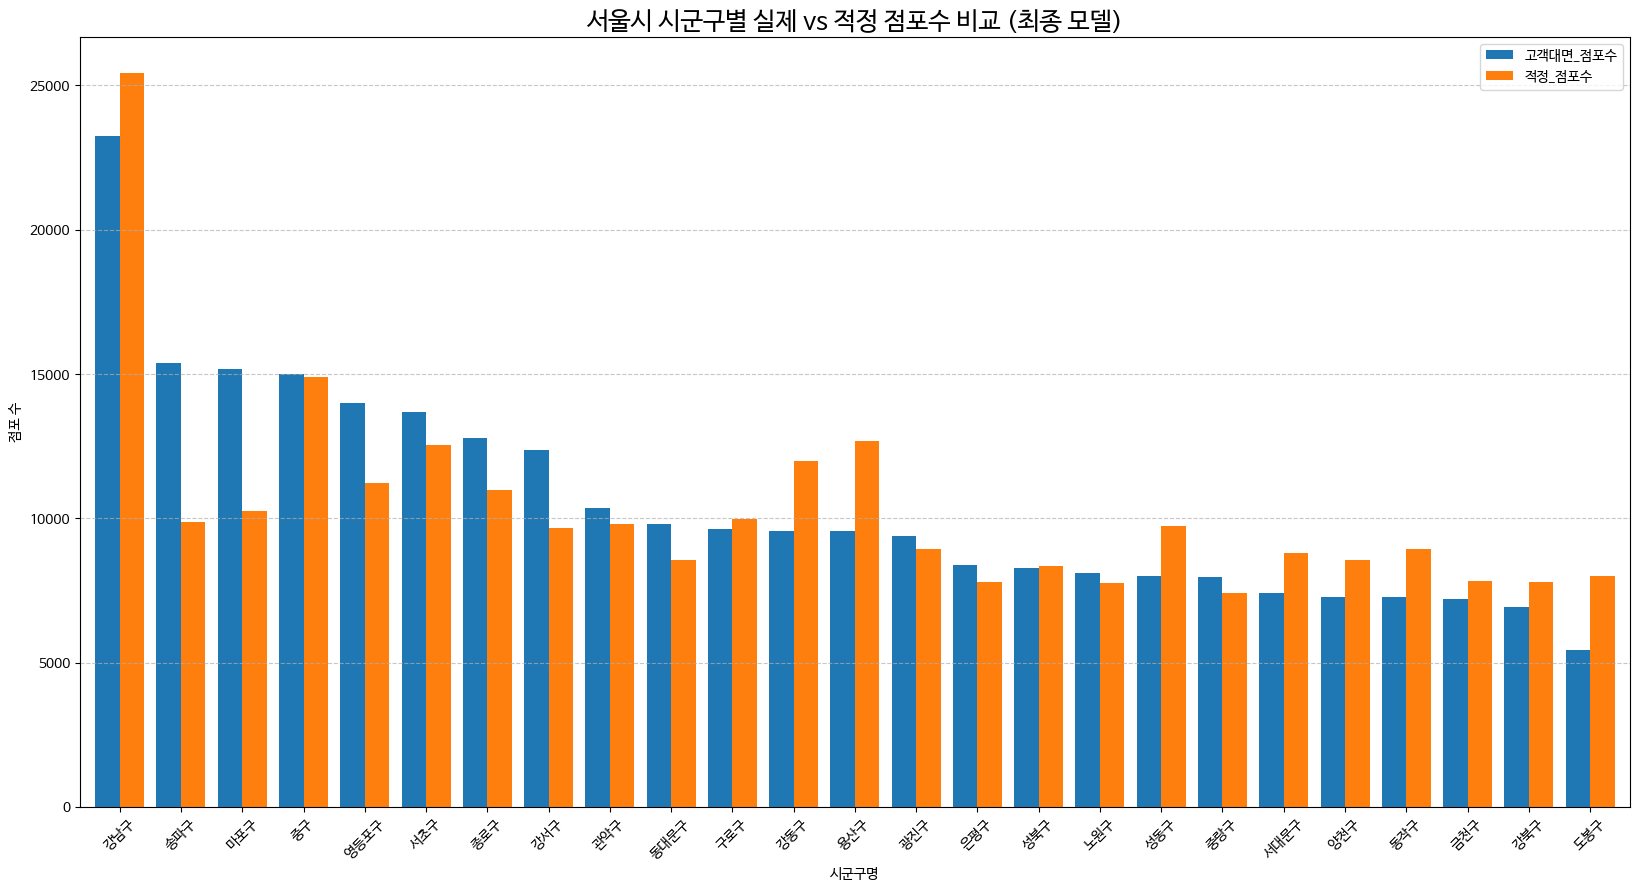


 최종 분석 결론

[모델 성능]
다양한 변수를 추가한 결과, 선형 회귀 모델은 시군구별 고객대면 점포 수 변화의 69.10%를 설명할 수 있게 되었습니다.

[핵심 요인]
분석 결과, OOO과 OOO이(가) 점포 수에 가장 큰 영향을 미치는 것으로 나타났습니다. (위 '변수 영향력' 표 참고)

[상권 포화도 분석]
  - 성장 잠재력 지역 (포화도 지수가 낮은 곳):


,고객대면_점포수,적정_점포수,포화도_지수
시군구명,,,
용산구,9549,12684,-3135
도봉구,5418,8008,-2590
강동구,9550,12001,-2451
강남구,23235,25415,-2180
성동구,8005,9738,-1733



  - 경쟁 심화 지역 (포화도 지수가 높은 곳):


,고객대면_점포수,적정_점포수,포화도_지수
시군구명,,,
송파구,15373,9885,5488
마포구,15159,10242,4917
영등포구,13987,11235,2752
강서구,12383,9680,2703
종로구,12791,10965,1826



[종합 제언]
이번 분석을 통해, 단순히 인구뿐만 아니라 대중교통, 직장인구 등 다양한 변수를 고려했을 때 각 지역의 상업적 잠재력(적정 점포수)을 더 정확하게 예측할 수 있었습니다.
이를 통해 실제 점포 수가 잠재력보다 낮은 '성장 잠재력 지역'을 구체적으로 발굴할 수 있으며, 이는 신규 창업 시 중요한 의사결정 근거가 될 수 있습니다.


In [23]:
#
# 셀 6: 최종 결과 시각화 및 결론
#

# 1. 시각화: 실제 점포수 vs 적정 점포수
print("--- 서울시 시군구별 실제 vs 적정 점포수 비교 ---")
df_view = df_final[['고객대면_점포수', '적정_점포수']].copy()
df_view.sort_values(by='고객대면_점포수', ascending=False, inplace=True)

df_view.plot(kind='bar', figsize=(20, 10), width=0.8)
plt.title("서울시 시군구별 실제 vs 적정 점포수 비교 (최종 모델)", fontsize=18)
plt.ylabel('점포 수')
plt.xlabel('시군구명')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 2. 최종 결론 텍스트
print("\n" + "="*60)
print(" 최종 분석 결론")
print("="*60)

print("\n[모델 성능]")
print(f"다양한 변수를 추가한 결과, 선형 회귀 모델은 시군구별 고객대면 점포 수 변화의 {r2:.2%}를 설명할 수 있게 되었습니다.")

print("\n[핵심 요인]")
print("분석 결과, OOO과 OOO이(가) 점포 수에 가장 큰 영향을 미치는 것으로 나타났습니다. (위 '변수 영향력' 표 참고)")

print("\n[상권 포화도 분석]")
print("  - 성장 잠재력 지역 (포화도 지수가 낮은 곳):")
display(df_final.sort_values(by='포화도_지수').head(5)[['고객대면_점포수', '적정_점포수', '포화도_지수']])
print("\n  - 경쟁 심화 지역 (포화도 지수가 높은 곳):")
display(df_final.sort_values(by='포화도_지수', ascending=False).head(5)[['고객대면_점포수', '적정_점포수', '포화도_지수']])

print("\n[종합 제언]")
print("이번 분석을 통해, 단순히 인구뿐만 아니라 대중교통, 직장인구 등 다양한 변수를 고려했을 때 각 지역의 상업적 잠재력(적정 점포수)을 더 정확하게 예측할 수 있었습니다.")
print("이를 통해 실제 점포 수가 잠재력보다 낮은 '성장 잠재력 지역'을 구체적으로 발굴할 수 있으며, 이는 신규 창업 시 중요한 의사결정 근거가 될 수 있습니다.")


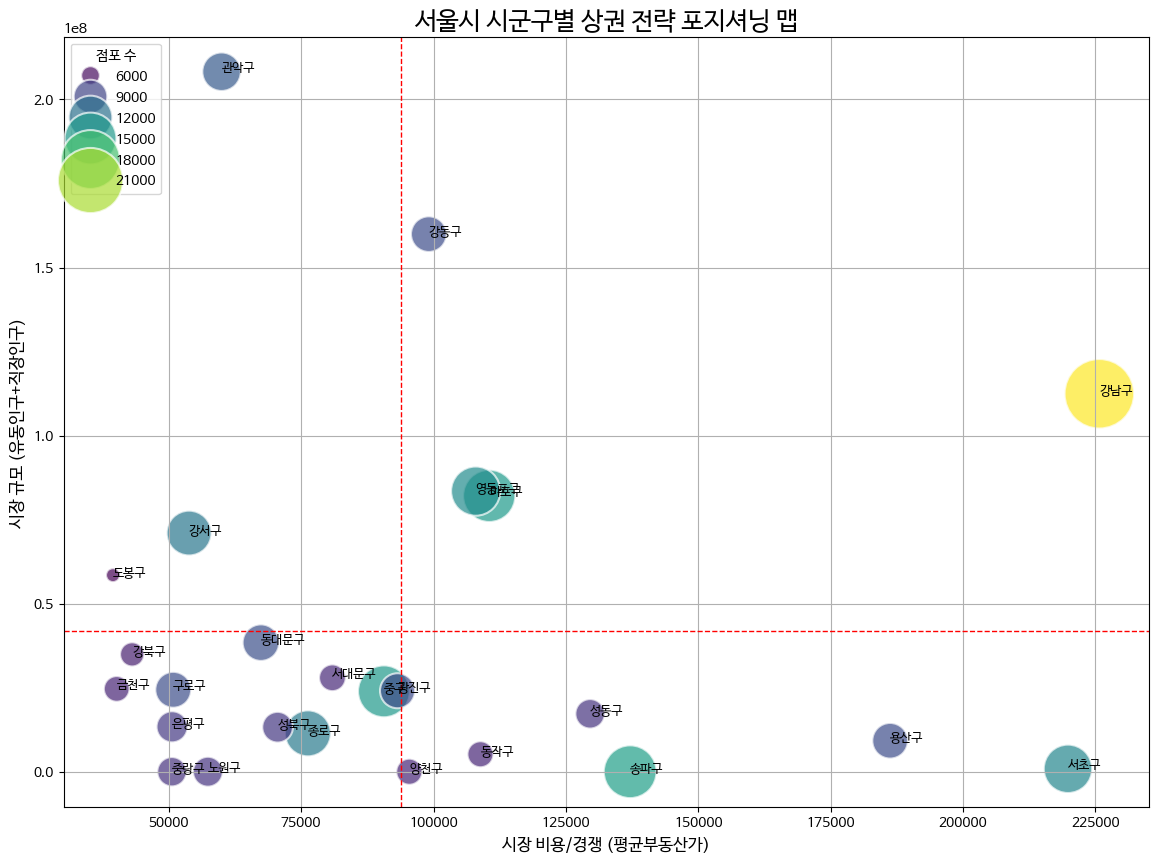

In [25]:
#
# 셀 별도1: 전략적 포지셔닝 맵
#
df_final['시장규모'] = df_final['총_유동인구_수'] + df_final['총_직장인구_수']

plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df_final,
    x='평균부동산가(만원)',
    y='시장규모',
    size='고객대면_점포수',
    hue='고객대면_점포수',
    sizes=(100, 2500),
    palette='viridis',
    alpha=0.7
)

for i in range(df_final.shape[0]):
    plt.text(df_final['평균부동산가(만원)'][i], df_final['시장규모'][i], df_final.index[i], fontsize=9)

plt.axhline(df_final['시장규모'].mean(), color='red', linestyle='--', linewidth=1)
plt.axvline(df_final['평균부동산가(만원)'].mean(), color='red', linestyle='--', linewidth=1)

plt.title('서울시 시군구별 상권 전략 포지셔닝 맵', fontsize=18)
plt.xlabel('시장 비용/경쟁 (평균부동산가)', fontsize=12)
plt.ylabel('시장 규모 (유동인구+직장인구)', fontsize=12)
plt.grid(True)
plt.legend(title='점포 수', loc='upper left')
plt.show()

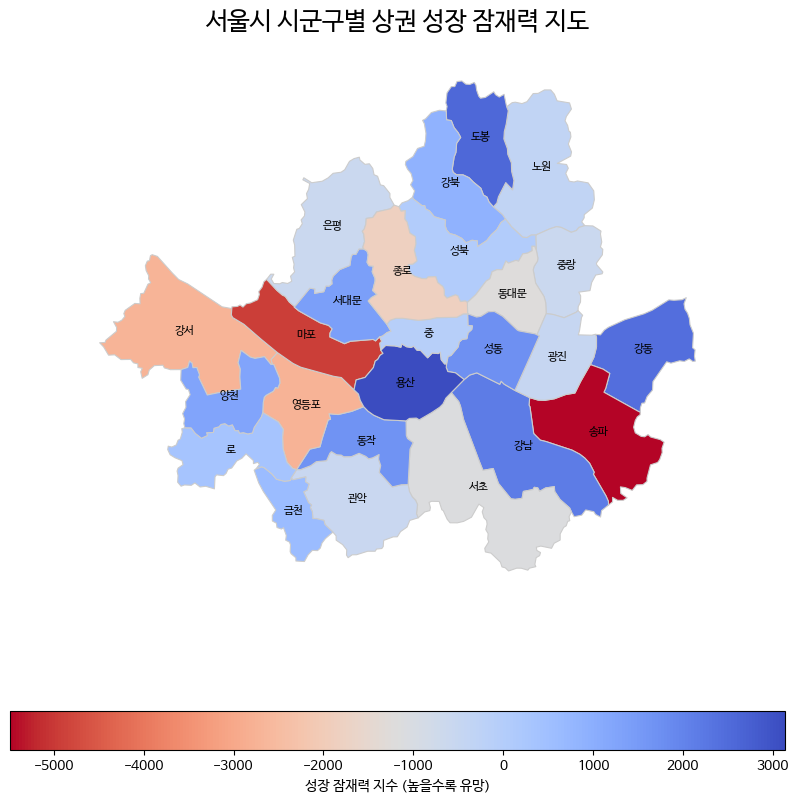

In [28]:
#
# 셀 별도2: 상권 기회 지도 시각화
#
# 시각화에 필요한 라이브러리를 불러옵니다.
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# df_final은 이전 셀들에서 실행되어, '적정_점포수'와 '고객대면_점포수'가 계산된 상태여야 합니다.
if '적정_점포수' in df_final.columns:

    # 1. 지도 데이터에 분석 결과 결합
    #https://github.com/southkorea/seoul-maps 서울에 관한 정보는 깃허브에 사람들이 잘 올려서 찾아보면 괜찮은것이 많음.
    map_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
    gdf_map = gpd.read_file(map_url)
    gdf_map.rename(columns={'name': '시군구명'}, inplace=True)

    # '잠재력_점수' 계산: (적정 점포수 - 실제 점포수). 높을수록 잠재력이 큼.
    df_final['잠재력_점수'] = df_final['적정_점포수'] - df_final['고객대면_점포수']

    # 지도 데이터와 분석 결과 데이터를 '시군구명'을 기준으로 결합
    gdf_map_result = pd.merge(gdf_map, df_final, on='시군구명', how='left')

    # 2. Choropleth 지도 시각화
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_map_result.plot(column='잠재력_점수',
                        cmap='coolwarm_r', # 높은 값(잠재력)은 파란색, 낮은 값(경쟁심화)은 붉은색
                        linewidth=0.8,
                        ax=ax,
                        edgecolor='0.8',
                        legend=True,
                        legend_kwds={'label': "성장 잠재력 지수 (높을수록 유망)",
                                     'orientation': "horizontal"})

    # 지도 위에 시군구 이름 표시
    for idx, row in gdf_map_result.iterrows():
        # 일부 시군구 이름이 길어 잘릴 경우를 대비해, '구'를 빼고 표시
        short_name = row['시군구명'].replace('구', '')
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, short_name, fontsize=8, ha='center', color='black')

    ax.set_title('서울시 시군구별 상권 성장 잠재력 지도', fontsize=18, pad=20)
    ax.axis('off') # 축 정보 숨기기
    plt.show()

else:
    print("‼️ 이전 셀에서 모델이 실행되지 않아 '적정_점포수'가 계산되지 않았습니다. 이전 셀들을 먼저 실행해주세요.")